Newton-Raphson Converged after  5 iterations
Initial number density, ni =  1.2918969375342138
Initial Pressure, P[0] =  0.4182722266764404
Simulation range, R = 0 to  90.36486611870906 km
Running RK4
P < 9e-05 found after 733 runs
Classical Model Results
Initial density, rho_s =  1665.3 MeV/fm3
Total mass =  10.0682352346512 times Solar mass
Radius of the Neutron star =  16.563502591901408 km
Running RK4
P < 9e-05 found after 430 runs
Relativistic Model Results
Initial density, rho_s =  1665.3 MeV/fm3
Total mass =  1.8765028084414366 times Solar mass
Radius of the Neutron star =  9.716652270828929 km


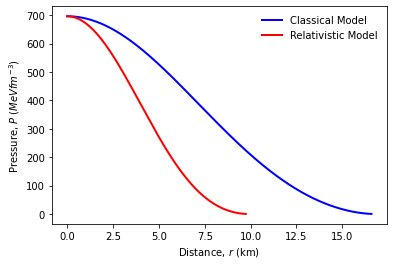

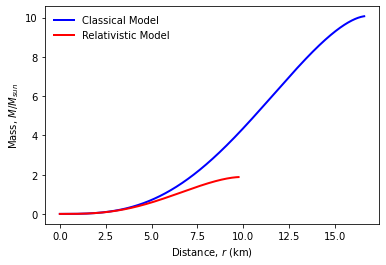

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Oct 27 21:40:45 2014
@author: Mohammad Asif Zaman
"""


# Using Plank system units (hcut = c = 1)
# Ref.: http://newfi.narod.ru/Newfi/Constants.htm

hc = 197.327                # Conversion factor in MeV fm (hut * c)
G = hc * 6.67259e-45        # Gravitational constant
Ms = 1.1157467e60
rho_s = 1665.3              # Central density (density at r = 0)
M0 = (4*3.14159265*(G**3)*rho_s)**(-0.5)
R0 = G*M0
mn = 938.926                # Mass of neutron in MeV c^-2


# Defining the functions

# Function for determining initial value of n(r=0)
def initial_n():          
    n = 1
    err = 1
    tol = 1e-15
    count = 0
    # Newton-Raphson method
    while err > tol : 
        count += 1
        fn = n*mn + 236*n**(2.54) - rho_s
        dfn = mn + 236*2.54*n**(1.54)
        temp = n - fn/dfn
        err = np.abs(n-temp)
        n = temp
    print("Newton-Raphson Converged after ", count, "iterations")
    return n
    
    
def rho(p):
    n = (p*rho_s/363.44)**(1./2.54)
    return (236. * n**2.54 + n *mn)/rho_s 
    

def dp_dr(r,m,p,flag):
    if flag == 0:                              # classical model
        y = -m*rho(p)/(r**2 + 1e-20)
    else:                                      # relativistic model
        rh = rho(p)                            
        y = -(p+rh)*(p*r**3 + m)/(r**2 - 2*m*r + 1e-20)
    return y

def dm_dr(r,m,p):
    return rho(p)*r**2
    

def EulerSolver(r,m,p,h,flag):
    y = np.zeros(2)
    y[0] = m + dm_dr(r,m,p)*h
    y[1] = p + dp_dr(r,m,p,flag)*h
    return y
    
def RK4Solver(r,m,p,h,flag):
    y = np.zeros(2)
    k11 = dm_dr(r,m,p)
    k21 = dp_dr(r,m,p,flag)
    
    k12 = dm_dr(r+0.5*h,m+0.5*k11*h,p+0.5*k21*h)
    k22 = dp_dr(r+0.5*h,m+0.5*k11*h,p+0.5*k21*h,flag)
    
    k13 = dm_dr(r+0.5*h,m+0.5*k12*h,p+0.5*k22*h)
    k23 = dp_dr(r+0.5*h,m+0.5*k12*h,p+0.5*k22*h,flag)
    
    k14 = dm_dr(r+h,m+h*k13,p+h*k23)    
    k24 = dp_dr(r+h,m+h*k13,p+h*k23,flag)    
    
    y[0] = m + h*(k11 + 2.*k12 + 2.*k13 + k14)/6.
    y[1] = p + h*(k21 + 2.*k22 + 2.*k23 + k24)/6.
    return y
    
    
def mplot(fign,x,y,xl,yl,clr,lbl):
    py.figure(fign)
    py.xlabel(xl)    
    py.ylabel(yl)
    return py.plot(x,y,clr, linewidth =2.0,label = lbl)
 




import time
import math
import matplotlib as mp
import numpy as np
import scipy as sp
import pylab as py



py.figure(1)
py.clf
py.figure(2)
py.clf


N = 4000
r = np.linspace(0,15,N)
h = r[1]-r[0]

m = np.zeros(N)
p = np.zeros(N)
rh = np.zeros(N)
ni = initial_n()

r[0]   = 0
m[0] = 0
p[0] = 363.44 * (ni**2.54)/rho_s
rh[0] = 1



flag_set = [0,1]
print("Initial number density, ni = ", ni)
print("Initial Pressure, P[0] = ", p[0])

print("Simulation range, R = 0 to ", r[-1]*R0*1e-18, "km") 
tol = 9e-5


# Looping over the two models (k = 0: classical, k = 1: relativistic)
for k in range(0,2):
    flag = flag_set[k]
    for i in range(0,N-1):
        [m[i+1], p[i+1]] = RK4Solver(r[i],m[i],p[i],h,flag)
        rh[i+1] = rho(r[i])
        if p[i+1] < tol:
            rf = r[i]
            mf = m[i]
            break
    
    print("Running RK4")
    if i == N-2:
        print("Program didn't converge to P = 0, extend the maximum value of r")
    else:
        print("P <", tol, "found after", i, "runs")
    print 
    
        
    m = m[0:i+2]
    p = p[0:i+2]
    rh = rh[0:i+2]
    r = r[0:i+2]
    
    if flag == 0:
        lbl = "Classical Model"
        clr = "blue"
    else:
        lbl = "Relativistic Model"
        clr = "red"
    
    
    print("==============================================")
    print(lbl, "Results")
    print("==============================================")
    print("Initial density, rho_s = ", rho_s, "MeV/fm3")
    print("Total mass = ", mf*M0/Ms, "times Solar mass")
    print("Radius of the Neutron star = ", rf*R0*1e-18, "km")


    mplot(1,r*R0*1e-18,p*rho_s,'Distance, $r$ (km)', 'Pressure, $P$ $(MeVfm^{-3})$',clr,lbl)
    mplot(2,r*R0*1e-18,m*M0/Ms,'Distance, $r$ (km)',r'Mass, $M/M_{sun}$',clr,lbl)
    
    
    
py.figure(1)
q = py.legend(loc = 0)
q.draw_frame(False)
py.figure(2)
q=py.legend(loc = 0)
q.draw_frame(False)

In [4]:
y=np.zeros(2)
y

array([0., 0.])